In [2]:
Одной из основных задач аналитика в нашей команде является корректное проведение экспериментов. 
Для этого мы применяем метод A/B–тестирования. 
В ходе тестирования одной гипотезы целевой группе была предложена новая механика оплаты услуг на сайте, у контрольной группы оставалась базовая механика. 
В качестве задания Вам необходимо проанализировать итоги эксперимента и сделать вывод, стоит ли запускать новую механику оплаты на всех пользователей.


In [7]:
# Подключаем необходимые библиотеки
import numpy as np
import pandas as pd
from scipy.stats import mannwhitneyu
from scipy.stats import ttest_ind
from scipy.stats import chi2_contingency, chi2
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.auto import tqdm
import seaborn as sns

plt.style.use('ggplot')

In [3]:
# Считываем данные
groups=pd.read_csv('Проект_2_groups.csv', sep=';')
active_studs=pd.read_csv('Проект_2_active_studs.csv')
checks=pd.read_csv('Проект_2_checks.csv', sep=';')

In [4]:
# Соединяем информацию активных пользователей в дни проведения эксперимента и их оплаты
checks_active_studs=active_studs.merge(checks, how='left', on='student_id')
checks_active_studs.head()

,student_id,rev
0,581585,NaN
1,5723133,NaN
2,3276743,NaN
3,4238589,NaN
4,4475369,NaN


In [5]:
# NAN означают что данные юзеры не совершали оплат в дни эксперимента, заменим их нулями и поменяем названия колонок
checks_active_studs=checks_active_studs.fillna(0).rename(columns={'student_id' : 'id'})

In [6]:
# Соединим нашу таблицу с таблицей groups
df=checks_active_studs.merge(groups, how='inner', on='id')
df.head()

,id,rev,grp
0,581585,0.0,A
1,3276743,0.0,B
2,4238589,0.0,A
3,4475369,0.0,B
4,5481015,0.0,B


In [8]:
# Т.к. изменения связаны с новой механикой на сайте в первую очередь интересно посмотреть изменения в конверсии.
# Возможно оплата на сайте стала более прозрачна и конверсия увеличилась
# Для этого нам интересно посмотреть сам факт совершения покупки (1 купили и 0 не купили)
df['purchase']=(df.rev>0)*1
df.head()

,id,rev,grp,purchase
0,581585,0.0,A,0
1,3276743,0.0,B,0
2,4238589,0.0,A,0
3,4475369,0.0,B,0
4,5481015,0.0,B,0


In [9]:
# Посмотрим CR по группам
df.groupby('grp', as_index=False).agg({'purchase' : 'mean'}).rename(columns=({'purchase' : 'CR'}))

,grp,CR
0,A,0.050814
1,B,0.046077


In [10]:
# На первый взгляд CR ухудшилась, но для того чтобы убедиться в этом воспользуемся Хи-квадрат тестом
df_pivot=df.groupby(['grp', 'purchase'],  as_index=False).agg({'id' : 'count'}).pivot(index='purchase', columns='grp', values='id')
df_pivot

grp,A,B
purchase,,
0,1457,6480
1,78,313


In [11]:
g, p, dof, expctd = chi2_contingency(df_pivot)
p

0.46803677583199144

In [ ]:
# Т.к р>0.05 то различия в CR между группами статистически не значимы

In [12]:
# тогда можно предположить, что есть разница в average revenue
df.query('rev>0').groupby('grp', as_index=False).agg({'rev' : 'mean'}).rename(columns=({'rev' : 'mean_rev'}))

,grp,mean_rev
0,A,933.589744
1,B,1255.827487


/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


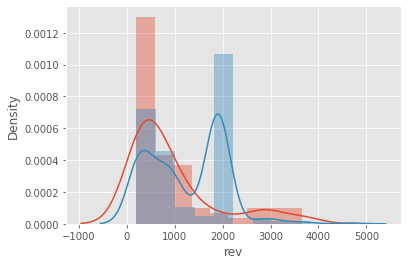

In [13]:
# Т.к. average revenue различаются, необходимо проверить эту гипотезу, для этого посмотрим распределения revenue по группам
sns.distplot(df.query('rev>0 & grp=="A"').rev)
sns.distplot(df.query('rev>0 & grp=="B"').rev)

In [14]:
# Т.к. распрежедения не нормальные, лучше всего применить bootstrap
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, # чтобы сохранить дисперсию, берем такой же размер выборки
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1-samples_2)) 
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    _, _, bars = plt.hist(pd_boot_data[0], bins = 50)
    for bar in bars:
        if abs(bar.get_x()) <= quants.iloc[0][0] or abs(bar.get_x()) >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(quants,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "quants": quants, 
            "p_value": p_value}

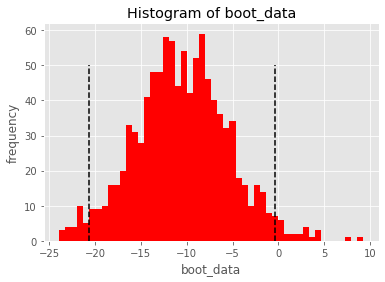

{'boot_data': [-9.57735956131312,
  -9.038275253937881,
  -13.548359075518917,
  -20.025615147946414,
  -5.947152068305609,
  -16.131753702340646,
  -16.012660518180482,
  -21.455174915354043,
  -13.63624373619903,
  -10.669218739879291,
  -11.326660223759754,
  -0.6444874871190946,
  -16.169145414397175,
  -14.529516090092745,
  -12.529221875460031,
  -14.44457576917415,
  -6.747829147651995,
  -12.413220020609455,
  -1.4952161342558528,
  -12.56587710878846,
  -8.297218195200944,
  -14.07684422199323,
  -11.497424319152069,
  -22.607243544825558,
  -3.6756960989253655,
  -3.8865012660091285,
  -9.446195127336967,
  -7.132931547180924,
  -3.962609009274254,
  -6.780068202561461,
  -9.198734594435448,
  -10.926689768879731,
  -19.1962320624172,
  -15.422788605917857,
  -21.88900403356396,
  -14.101722876490506,
  -6.2621820844987495,
  -11.514942293537466,
  -5.561460797880172,
  -19.534374179302223,
  -8.9496546150449,
  -13.295304607684383,
  -12.404240026497868,
  -17.21831345502723

In [15]:
get_bootstrap(
    df[df.grp == 'A'].rev, # числовые значения первой выборки
    df[df.grp == 'B'].rev, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
)

In [ ]:
# Т.к р<0.05 то различия в average revenue между группами статистически значимы

In [ ]:
# Исходя из результатов проверки эксперимента можно сказать следующее:
# У целевой группы увеличился средний чек и нет статистически значимого ухудшения в конверсии с контрольной группой - можно запускать новую механику оплаты
# Можно предположить, что новая механика связана с продвижением доп.товаров при оплате(механика должна увеличить выручку но и не отпугнуть клиента)

In [ ]:
# Реализуйте функцию, которая будет автоматически подгружать информацию из дополнительного файла groups_add.csv (заголовки могут отличаться) и на основании дополнительных параметров пересчитывать метрики.
# Реализуйте функцию, которая будет строить графики по получаемым метрикам.

In [16]:
def add_file(x):
    add_file=pd.read_csv(x)
    active_studs=pd.read_csv('Проект_2_active_studs.csv')
    checks=pd.read_csv('Проект_2_checks.csv', sep=';')
    checks_active_studs=active_studs.merge(checks, how='left', on='student_id')
    checks_active_studs=checks_active_studs.fillna(0).rename(columns={'student_id' : 'id'})
    full=pd.concat([groups, add_file])
    df=checks_active_studs.merge(full, how='inner', on='id')
    df['purchase']=(df.rev>0)*1
    CR=df.groupby('grp', as_index=False).agg({'purchase' : 'mean'}).rename(columns=({'purchase' : 'CR'}))
    AVG=df.query('rev>0').groupby('grp', as_index=False).agg({'rev' : 'mean'}).rename(columns=({'rev' : 'mean_rev'}))
    return ({'CR' : CR, 'AVG' : AVG})

In [17]:
recalculate=add_file('Проект_2_group_add.csv')
recalculate

{'CR':   grp        CR
 0   A  0.050715
 1   B  0.046156,
 'AVG':   grp     mean_rev
 0   A   933.589744
 1   B  1257.878992}

In [18]:
def barplot(recalculate):
    fig, axes = plt.subplots(1, 2, figsize=(18, 8))
    sns.barplot(ax=axes[0], x='grp', y='mean_rev', data=recalculate['AVG'])
    sns.barplot(ax=axes[1], x='grp', y='CR', data=recalculate['CR'])

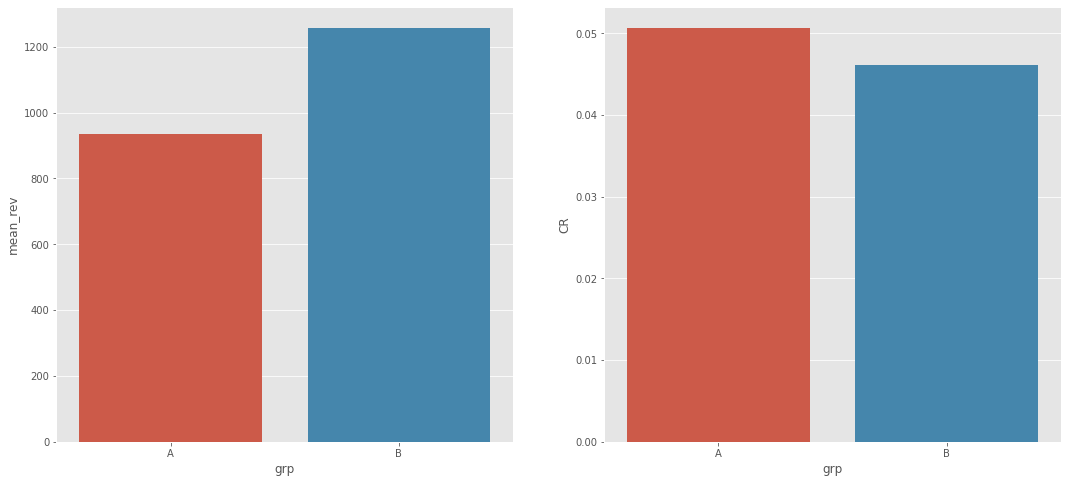

In [19]:
barplot(recalculate)